### DenseCRF
[Efficient Inference in Fully Connected CRFs with Gaussian Edge Potentials](
https://doi.org/10.48550/arXiv.1210.5644)  
Philipp Krähenbühl and Vladlen Koltun  
NIPS 2011

In [1]:
pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-gogjid5v
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-gogjid5v
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp310-cp310-linux_x86_64.whl size=3405173 sha256=ca237c20490b16234792d4970c2419d12f4217b8db20895e8ccb0c7201e08b90
  Stored in directory: /tmp/pip-ephem-wheel-cache-up4npxpt/wheels/01/5b/61/87443ed3bf03dd2940375cf2f8b6fba88efece935465e490b0
Successfully built pydensecrf


In [2]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral

### CryoParticleSegment

In [3]:
#%%bash
#git clone git+https://cyanazuki@github.com/cyanazuki/CryoParticleSegment.git
#cd CryoParticleSegment
#python setup.py install

## ⭐ Setup
You must run all codes under this category.

### ✅ Directory Settings

In [4]:
# @title  { display-mode: "form" }

IMAGE_DIR = "/content/drive/MyDrive/research_xs/processed_micrographs_np" # @param {type:"string"}
LABEL_DIR = "/content/drive/MyDrive/research_xs/ground_truth_mask" # @param {type:"string"}
RESULT_DIR = "/content/drive/MyDrive/research_xs/final/fcn_resnet101/pydensecrf" # @param {type:"string"}

In [5]:
# @title  { display-mode: "form" }
# @markdown Detect whether using folder in Google Drive as **`RESULT DIR`**📁.

if "content" in IMAGE_DIR.split("/")[:3] or "content" in LABEL_DIR.split("/")[:3]:
  try:
    from google.colab import drive
    drive.mount('/content/drive')
    !rm -r /content/sample_data
    if "content" in IMAGE_DIR.split("/")[:3]:
      !cp -r {IMAGE_DIR} /content/image_dir
      IMAGE_DIR = "/content/image_dir"
    if "content" in LABEL_DIR.split("/")[:3]:
      !cp -r {LABEL_DIR} /content/label_dir
      LABEL_DIR = "/content/label_dir"
  except:
    pass

Mounted at /content/drive


In [6]:
# @title  { display-mode: "form" }
# @markdown Source code directory.
SRC_DIR = "/content/drive/MyDrive/research/src" # @param {type:"string"}

if True:
  !cp -r {SRC_DIR}/EM_project/*.py /content/
else:
  !cp {SRC_DIR}/EM_project/convcrf.py /content/convcrf.py
  !cp {SRC_DIR}/EM_project/dataset.py /content/dataset.py
  !cp {SRC_DIR}/EM_project/lr_scheduler.py /content/lr_scheduler.py
  !cp {SRC_DIR}/EM_project/metrics.py /content/metrics.py
  !cp {SRC_DIR}/EM_project/model.py /content/model.py
  !cp {SRC_DIR}/EM_project/trainer.py /content/trainer.py
  !cp {SRC_DIR}/EM_project/utils.py /content/utils.py

### ✅ Packages Handling

In [7]:
# @title  { display-mode: "form" }
# @markdown Useful packages.

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.utils import save_image
from torch.utils.data import DataLoader

In [8]:
# @title  { display-mode: "form" }
# @markdown User-defined packages.

from dataset import MicrographDataset, MicrographDatasetEvery
from dataset import reconstruct_patched
from model import create_model
from trainer import CryoEMEvaluator

## ⭐ Main

### ✅ Setting

In [9]:
# @markdown Parameters.

NUM_CLASSES = 2
# EPOCHS = 100
# BATCH = 7
CROP_SIZE = (512, 512)
# LR = 1e-3
# RLR_PATIENCE = 3
# ES_PATIENCE = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# @markdown Set seed.

random_state = 42
torch.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state)

### ✅ Dataset

In [11]:
train_dir = os.path.join(IMAGE_DIR, 'train')
train_filenames = np.loadtxt(f"{IMAGE_DIR}/train_filenames.txt", dtype=str)
train_dataset = MicrographDataset(image_dir=train_dir, label_dir=LABEL_DIR, filenames=train_filenames, crop_size=CROP_SIZE)

In [12]:
val_dir = os.path.join(IMAGE_DIR, 'val')
val_filenames = np.loadtxt(f"{IMAGE_DIR}/val_filenames.txt", dtype=str)
val_dataset = MicrographDatasetEvery(image_dir=val_dir, label_dir=LABEL_DIR, filenames=val_filenames, crop_size=CROP_SIZE)
val_loader = DataLoader(val_dataset, batch_size=None, shuffle=False, pin_memory=True)

In [13]:
test_dir = os.path.join(IMAGE_DIR, 'test')
test_filenames = np.loadtxt(f"{IMAGE_DIR}/test_filenames.txt", dtype=str)
test_dataset = MicrographDatasetEvery(image_dir=test_dir, label_dir=LABEL_DIR, filenames=test_filenames, crop_size=CROP_SIZE)
test_loader = DataLoader(test_dataset, batch_size=None, shuffle=False, pin_memory=True)

### ✅ Model

In [14]:
backbone = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet101', num_classes=NUM_CLASSES)

backbone.backbone.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
backbone.classifier[3].p = 0.5

model = create_model(backbone)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 153MB/s]


## ⭐ Evaluate

### ✅ Load model

In [15]:
CHECKPOINT_PATH = "/content/drive/MyDrive/research_xs/final/fcn_resnet101/checkpoint74_B7_L-3_C512.pt" # @param {type:"string"}
state_dict_path = CHECKPOINT_PATH
state_dict = torch.load(state_dict_path, map_location=torch.device(DEVICE))
model.load_state_dict(state_dict, strict=False)
model.to(DEVICE)
model.eval()
print("Load model at: ", state_dict_path)

Load model at:  /content/drive/MyDrive/research_xs/final/fcn_resnet101/checkpoint74_B7_L-3_C512.pt


In [16]:
import gc
gc.collect()
torch.cuda.empty_cache()

### ✅ Evalutor

In [17]:
evaluator = CryoEMEvaluator(model=model, device=DEVICE, metrics=['iou'], num_classes=NUM_CLASSES)
print("FCN validation result:")
result = evaluator.evaluate(loader=val_loader)
print("FCN test result:")
result = evaluator.evaluate(loader=test_loader)

FCN validation result:
global correct: 91.44
average row correct: ['94.86', '80.98']
Recall: ['93.85', '83.75']
IoU: ['89.30', '69.99']
F1 Score: ['94.35', '82.34']
mean IoU: 79.65
FCN test result:
global correct: 90.29
average row correct: ['94.27', '76.50']
Recall: ['93.30', '79.37']
IoU: ['88.29', '63.81']
F1 Score: ['93.78', '77.91']
mean IoU: 76.05


### ✅ Evaluate pydensecrf

In [18]:
# @markdown Class and function for densecrf.

# @markdown create_pairwise_bilateral 要兩分鐘 (共135秒)
SaveImage = True # @param {type:"boolean"}
HideKLdivergence = False # @param {type:"boolean"}
sdims = (10, 10) # @param {type:"raw"}
schan = (0.5,) # @param {type:"raw"}
compat = 1 # @param {type:"raw"}

class DensecrfEvaluator(CryoEMEvaluator):
  def __init__(self, model, device, metrics, num_classes: int = 2, inference_iteration = 10, *arg, **kwarg):
    super().__init__(model, device, metrics, num_classes, *arg, **kwarg)
    self.iteration = inference_iteration

  def evaluate(self, loader, end_string: str=None):
    os.makedirs(f"{RESULT_DIR}/ITERATION_{self.iteration}", exist_ok=True)
    self.model.eval()
    self.initialize_evaluate(num_of_step=len(loader))
    with torch.no_grad():
      for batch_idx, (inputs, targets, grid, *_) in enumerate(loader):
        inputs = inputs.to(self.device)
        targets = targets.to(self.device)
        outputs = self.model(inputs)['out']
        inputs = reconstruct_patched(inputs, grid)[None, :]
        targets = reconstruct_patched(targets, grid)[None, :]
        outputs = reconstruct_patched(outputs, grid)[None, :]
        # Evaluating
        self.step_evaluate(inputs, outputs, targets, batch_idx)
    results = self.end_evaluate(end_string)
    gc.collect()
    torch.cuda.empty_cache()
    return results

  def step_evaluate(self, inputs, outputs, targets, batch_idx):
    shape = inputs.shape
    start_time = time.time()
    d = dcrf.DenseCRF2D(*shape[-2:], self.num_classes)
    U = unary_from_softmax(outputs.detach().cpu().numpy()).reshape((self.num_classes,-1))
    d.setUnaryEnergy(U)
    pairwise_energy = create_pairwise_bilateral(
        sdims=sdims, schan=schan, img=inputs[:,:1,:,:].detach().cpu().numpy(), chdim=1)
    d.addPairwiseEnergy(pairwise_energy, compat=compat)
    if HideKLdivergence:
      Q = d.inference(self.iteration)
    else:
      Q, tmp1, tmp2 = d.startInference()
      for i in range(self.iteration):
        print("\t\tKL-divergence at {}: {}".format(i, d.klDivergence(Q)))
        d.stepInference(Q, tmp1, tmp2)
    end_time = time.time()
    # map = np.argmax(Q, axis=0).reshape(*shape[-2:])
    outputs = torch.Tensor(np.array(Q).reshape(shape[-4], self.num_classes, *shape[-2:])).to(self.device)
    super(DensecrfEvaluator, self).step_evaluate(inputs, outputs, targets, batch_idx)
    print(f"\tTime usage of image {batch_idx}: {end_time-start_time}")
    if SaveImage:
      preds = outputs.argmax(dim=1).cpu().detach()
      filename = f"{os.path.splitext(test_dataset.filenames[batch_idx])[0]}.png"
      pred_path = os.path.join(RESULT_DIR, f"ITERATION_{self.iteration}", filename)
      # save_image(reconstruct_patched(preds, grid).float(), pred_path)
      save_image(preds.float(), pred_path)
      print(f"Save image:{filename}")

In [19]:
# @markdown Evaluate densecrf on cryoem data
ITERATION = 10 # @param {type:"integer"}
evaluator = DensecrfEvaluator(
    model=model, device=DEVICE, metrics=['iou'],
    num_classes=NUM_CLASSES, inference_iteration = ITERATION)
print("CRF validation result:")
result = evaluator.evaluate(loader=val_loader)
print("CRF test result:")
result = evaluator.evaluate(loader=test_loader)

CRF validation result:
		KL-divergence at 0: -12997805.133453505
		KL-divergence at 1: -13118664.137954613
		KL-divergence at 2: -13127899.656795284
		KL-divergence at 3: -13129422.128900144
		KL-divergence at 4: -13129752.03610467
		KL-divergence at 5: -13129832.486220604
		KL-divergence at 6: -13129856.985344905
		KL-divergence at 7: -13129862.932424145
		KL-divergence at 8: -13129865.463202849
		KL-divergence at 9: -13129865.677278059
	Time usage of image 0: 85.06058740615845
Save image:Falcon_2012_06_12-15_07_41_0.png
		KL-divergence at 0: -13246671.075835923
		KL-divergence at 1: -13352663.406832429
		KL-divergence at 2: -13360828.089905988
		KL-divergence at 3: -13362209.36052228
		KL-divergence at 4: -13362521.418800617
		KL-divergence at 5: -13362600.888435265
		KL-divergence at 6: -13362610.240793454
		KL-divergence at 7: -13362615.528381314
		KL-divergence at 8: -13362616.098595547
		KL-divergence at 9: -13362617.303898763
	Time usage of image 1: 88.3932192325592
Save image:F

In [ ]:
# @markdown Evaluate densecrf on cryoem data
ITERATION = 20 # @param {type:"integer"}
evaluator = DensecrfEvaluator(
    model=model, device=DEVICE, metrics=['iou'],
    num_classes=NUM_CLASSES, inference_iteration = ITERATION)
print("CRF validation result:")
result = evaluator.evaluate(loader=val_loader)
print("CRF test result:")
result = evaluator.evaluate(loader=test_loader)

CRF validation result:
		KL-divergence at 0: -133838678.15337963
		KL-divergence at 1: -143599943.4906865
		KL-divergence at 2: -144999252.49059266
		KL-divergence at 3: -145306120.12783402
		KL-divergence at 4: -145388584.65368962
		KL-divergence at 5: -145416716.7989498
		KL-divergence at 6: -145429508.79343748
		KL-divergence at 7: -145436749.7467575
		KL-divergence at 8: -145441502.28364512
		KL-divergence at 9: -145444658.73675662
		KL-divergence at 10: -145446946.97941485
		KL-divergence at 11: -145448861.3545218
		KL-divergence at 12: -145450268.22663137
		KL-divergence at 13: -145451285.73960057
		KL-divergence at 14: -145452050.4197854
		KL-divergence at 15: -145452634.74460977
		KL-divergence at 16: -145453144.57671863
		KL-divergence at 17: -145453663.8167148
		KL-divergence at 18: -145454055.75667697
		KL-divergence at 19: -145454372.53127432
	Time usage of image 0: 346.0262460708618
		KL-divergence at 0: -136664521.21433324
		KL-divergence at 1: -144514180.25721025
		KL-di

### pydensecrf

#### One patch

In [ ]:
# @markdown Define function.
def crf_predict(images, target, grid, patch_idx, inference_iteration=10):
  model.eval()
  with torch.no_grad():
    input = images[patch_idx:patch_idx+1].to(DEVICE)
    unary = model(input)['out']
    d = dcrf.DenseCRF2D(*CROP_SIZE, NUM_CLASSES)
    U = unary_from_softmax(unary.detach().cpu().numpy()).reshape((NUM_CLASSES,-1))
    d.setUnaryEnergy(U)
    pairwise_energy = create_pairwise_bilateral(
        sdims=(10,10), schan=(0.01,), img=images[patch_idx:patch_idx+1,:1,:,:].numpy(), chdim=1)
    d.addPairwiseEnergy(pairwise_energy, compat=10)
    start_time = time.time()
    Q = d.inference(inference_iteration)
    end_time = time.time()
    map = np.argmax(Q, axis=0).reshape(CROP_SIZE)
    proba = np.array(Q).reshape(NUM_CLASSES, *CROP_SIZE)
    time_usage = end_time-start_time
    return proba, unary, time_usage

def plot_crf_result(image, target, unary, crf_output, time_usage=None):
  fig, ax = plt.subplots(2,2, figsize=(6,6))
  axes = ax.flatten()
  axes[0].imshow(image, cmap='gray')
  axes[0].set_title('Micrograph patch')
  axes[0].axis('off')
  axes[1].imshow(target, cmap='gray')
  axes[1].set_title('Ground truth patch')
  axes[1].axis('off')
  axes[2].imshow(-unary, cmap='inferno')
  axes[2].set_title('CNN prediction')
  axes[2].axis('off')
  axes[3].imshow(-crf_output, cmap='inferno')
  axes[3].set_title('denseCRF result')
  axes[3].axis('off')
  plt.tight_layout()
  if time_usage is not None:
    print(f"Time usage:{time_usage}")

Time usage:0.6828985214233398


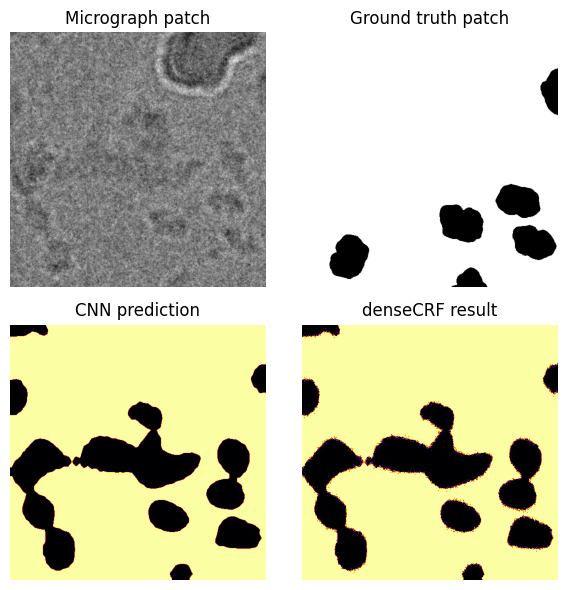

In [ ]:
# @title One patch { run: "auto" }
# @markdown Set inference_iteration to over 10000 will cause crash
ITERATION = 10 # @param {type:"integer"}
patch_idx = 0 # @param {type:"slider", min:0, max:63, step:1}
images, target, grid, _ = test_dataset[0]
crf_output, unary, time_usage = crf_predict(images, target, grid, patch_idx, ITERATION)
plot_crf_result(
    images[patch_idx,0,:,:].numpy(),
    target[patch_idx,0,:,:].numpy(),
    unary[0].detach().cpu().numpy().argmax(-3),
    crf_output.argmax(-3), time_usage=time_usage)

#### Entire Micrograph

inference(1000) 跑51分7秒沒跑完

In [ ]:
ITERATION = 10 # @param {type:"integer"}

model.eval()
with torch.no_grad():
  images, target, grid, _ = test_dataset[0]
  inputs = images.to(DEVICE)
  input_micrograph = reconstruct_patched(images, grid).numpy()
  outputs = model(inputs)['out']
  unary_micrograph = reconstruct_patched(outputs, grid).detach().cpu().numpy()
  shape_micrograph = unary_micrograph.shape
  d = dcrf.DenseCRF2D(*shape_micrograph[-2:], NUM_CLASSES)
  U = unary_from_softmax(unary_micrograph).reshape((NUM_CLASSES,-1))
  d.setUnaryEnergy(U)
  pairwise_energy = create_pairwise_bilateral(
      sdims=(10,10), schan=(0.01,),
      img=input_micrograph[None, :], chdim=1)
  d.addPairwiseEnergy(pairwise_energy, compat=10)
  Q = d.inference(ITERATION)
  map = np.argmax(Q, axis=0).reshape(*shape_micrograph[-2:])
  proba = np.array(Q).reshape(-1, *shape_micrograph[-2:])
  prediction = proba.argmax(0)

In [ ]:
# @markdown Seperate handle densecrf on each patches
RUN = False # @param {type:"boolean"}
if RUN:
  ITERATION = 10 # @param {type:"integer"}
  model.eval()
  with torch.no_grad():
    images, target, grid, _ = test_dataset[0]
    images_proba = list()
    for patch_idx, _ in enumerate(images):
      input = images[patch_idx:patch_idx+1].to(DEVICE)
      unary = model(input)['out']
      d = dcrf.DenseCRF2D(*CROP_SIZE, NUM_CLASSES)
      U = unary_from_softmax(unary.detach().cpu().numpy()).reshape((NUM_CLASSES,-1))
      d.setUnaryEnergy(U)
      pairwise_energy = create_pairwise_bilateral(
          sdims=(10,10), schan=(0.01,), img=images[patch_idx:patch_idx+1,:1,:,:].numpy(), chdim=1)
      d.addPairwiseEnergy(pairwise_energy, compat=10)
      Q = d.inference(ITERATION)
      map = np.argmax(Q, axis=0).reshape(CROP_SIZE)
      proba = np.array(Q)
      images_proba.append(proba.reshape(NUM_CLASSES, *CROP_SIZE))
    images_proba = torch.Tensor(np.asarray(images_proba))
    reconstruct_outputs = reconstruct_patched(images_proba, grid)

(-0.5, 3839.5, 3839.5, -0.5)

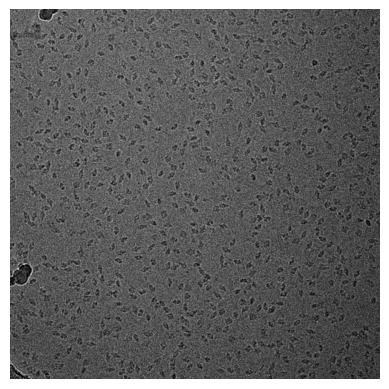

In [ ]:
plt.imshow(np.clip(input_micrograph,-3,3)[0], cmap="gray")
plt.axis("off")

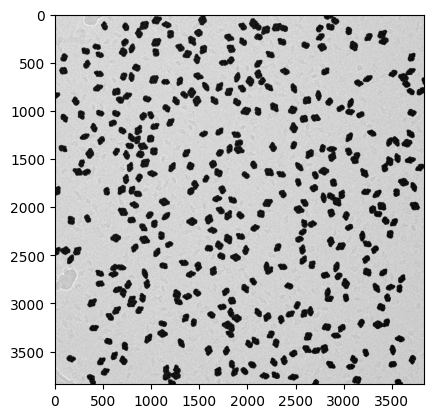

In [ ]:
plt.imshow(np.clip(reconstruct_patched(images, grid)[0],-3,3)+reconstruct_patched(target[:,0], grid), cmap="gray")
plt.imshow(reconstruct_patched(target[:,0], grid), cmap="gray", alpha=0.7)

NameError: name 'reconstruct_outputs' is not defined

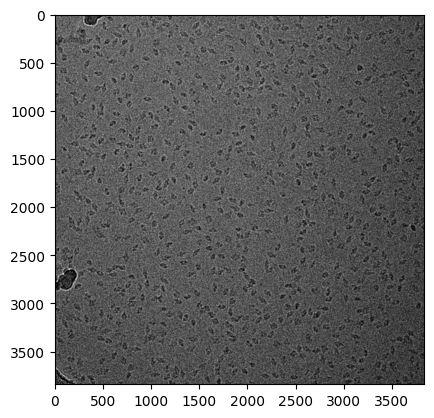

In [ ]:
plt.imshow(np.clip(reconstruct_patched(images, grid)[0],-3,3), cmap="gray")
plt.imshow(1-reconstruct_outputs.argmax(dim=0), cmap="inferno", alpha=0.3)
# plt.imshow(1-reconstruct_outputs.argmax(dim=0).cpu().detach().float(), cmap="inferno", alpha=0.3)

### ✅ Testing

In [ ]:
# evaluator = CryoEMEvaluator(model=model, device=DEVICE, metrics=['iou'], num_classes=NUM_CLASSES)
# result = trainer.evaluate(test_loader)

In [ ]:
from torchvision.utils import save_image
from dataset import reconstruct_patched

ITERATION = 20

!mkdir {RESULT_DIR}/ITERATION_{ITERATION}
model.eval()
with torch.no_grad():
  for idx, (test_image, _, grid, _) in enumerate(test_loader):
    inputs = test_image.to(DEVICE)
    outputs = model(inputs)['out']
    inputs = reconstruct_patched(inputs, grid)[None, :]
    shape = inputs.shape
    outputs = reconstruct_patched(outputs, grid)[None, :]
    d = dcrf.DenseCRF2D(*shape[-2:], NUM_CLASSES)
    U = unary_from_softmax(outputs.detach().cpu().numpy()).reshape((NUM_CLASSES,-1))
    d.setUnaryEnergy(U)
    pairwise_energy = create_pairwise_bilateral(
        sdims=(10,10), schan=(0.01,), img=inputs[:,:1,:,:].detach().cpu().numpy(), chdim=1)
    d.addPairwiseEnergy(pairwise_energy, compat=10)
    Q = d.inference(ITERATION)
    outputs = torch.Tensor(np.array(Q).reshape(shape[-4], NUM_CLASSES, *shape[-2:])).to(DEVICE)
    preds = outputs.argmax(dim=1).cpu().detach()
    filename = f"{os.path.splitext(test_dataset.filenames[idx])[0]}.png"
    pred_path = os.path.join(RESULT_DIR, f"ITERATION_{ITERATION}", filename)
    # save_image(reconstruct_patched(preds, grid).float(), pred_path)
    save_image(preds.float(), pred_path)
    print(f"Save image:{filename}")

Save image:Falcon_2012_06_12-15_07_41_0.png
Save image:Falcon_2012_06_12-15_17_31_0.png
Save image:Falcon_2012_06_12-15_30_21_0.png
Save image:Falcon_2012_06_12-15_46_37_0.png
Save image:Falcon_2012_06_12-16_55_40_0.png
Save image:Falcon_2012_06_12-17_23_32_0.png
Save image:Falcon_2012_06_12-17_46_08_0.png
Save image:Falcon_2012_06_13-01_16_43_0.png
Save image:Falcon_2012_06_13-01_39_04_0.png
Save image:Falcon_2012_06_13-01_56_06_0.png
Save image:Falcon_2012_06_13-01_58_43_0.png
Save image:Falcon_2012_06_13-02_39_18_0.png
Save image:Falcon_2012_06_13-02_52_54_0.png
Save image:Falcon_2012_06_13-02_55_34_0.png
Save image:Falcon_2012_06_13-03_06_44_0.png
Save image:Falcon_2012_06_13-03_17_02_0.png
Save image:Falcon_2012_06_13-03_19_23_0.png


# N

### pydensecrf with feature

In [ ]:
# @title Codes

from copy import deepcopy
from collections import OrderedDict

def crf_feat_predict(images, target, grid, patch_idx, inference_iteration=10, feature_num=100):
  model.eval()
  with torch.no_grad():
    input = images[patch_idx:patch_idx+1].to(DEVICE)
    unary = model(input)['out']
    feats = model2(input)['out'][:,:feature_num,:,:]
    d = dcrf.DenseCRF2D(*CROP_SIZE, NUM_CLASSES)
    U = unary_from_softmax(unary.detach().cpu().numpy()).reshape((NUM_CLASSES,-1))
    d.setUnaryEnergy(U)
    pairwise_energy = create_pairwise_bilateral(
        sdims=(10,10), schan=(0.01,), img=images[patch_idx:patch_idx+1,:1,:,:].numpy(), chdim=1)
    d.addPairwiseEnergy(pairwise_energy, compat=10)
    d.addPairwiseEnergy(feats.detach().cpu().numpy().reshape((feature_num,-1)), compat=0.1)
    start_time = time.time()
    Q = d.inference(inference_iteration)
    end_time = time.time()
    map = np.argmax(Q, axis=0).reshape(CROP_SIZE)
    proba = np.array(Q).reshape(NUM_CLASSES, *CROP_SIZE)
    time_usage = end_time-start_time
    return proba, unary, time_usage

def plot_crf_result(image, target, unary, crf_output, time_usage=None):
  fig, ax = plt.subplots(2,2, figsize=(6,6))
  axes = ax.flatten()
  axes[0].imshow(image, cmap='gray')
  axes[0].set_title('Micrograph patch')
  axes[0].axis('off')
  axes[1].imshow(target, cmap='gray')
  axes[1].set_title('Ground truth patch')
  axes[1].axis('off')
  axes[2].imshow(-unary, cmap='inferno')
  axes[2].set_title('CNN prediction')
  axes[2].axis('off')
  axes[3].imshow(-crf_output, cmap='inferno')
  axes[3].set_title('denseCRF result')
  axes[3].axis('off')
  plt.tight_layout()
  if time_usage is not None:
    print(f"Time usage:{time_usage}")

model2 = deepcopy(model)
model2.classifier = torch.nn.Sequential(OrderedDict([*(list(model.classifier.named_children())[:-3])]))

In [ ]:
# @title One patch pydensecrf with feature { run: "auto" }
# @markdown This process will crash
inference_iteration = 10 # @param {type:"integer"}
patch_idx = 0 # @param {type:"slider", min:0, max:63, step:1}
images, target, grid, _ = test_dataset[0]

crf_output, unary, time_usage = crf_feat_predict(images, target, grid, patch_idx, inference_iteration)
plot_crf_result(
    images[patch_idx,0,:,:].numpy(),
    target[patch_idx,0,:,:].numpy(),
    unary[0].detach().cpu().numpy().argmax(-3),
    crf_output.argmax(-3), time_usage=time_usage)